# Ecoli Case (K12, 4587) for RXNRecer

> author: Shizhenkun   
> email: zhenkun.shi@tib.cas.cn   
> date: 2024-10-16  


## 1. Import packages

In [2]:
import sys,os
sys.path.insert(0, os.path.dirname(os.path.realpath('__file__')))
sys.path.insert(1,'../../')
sys.path.insert(1,'../methods/active-learning/')
from config import conf as cfg
from tools import uniprottool as uptool
from tools import  bioFunctionLib as bfl
import production.production as production
from modules import commonfunction as cmfunc
from tqdm import tqdm
import re
from IPython.display import display_markdown
from pandarallel import pandarallel # 导入pandaralle
pandarallel.initialize(progress_bar=False)
from tkinter import _flatten
import json
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib_venn import venn2,venn3

FIRST_TIME_RUN = False # For the initial run, please set this flag to True. This will allow the program to download data from UniProt and RHEA, which may take longer depending on your internet speed.

%load_ext autoreload
%autoreload 2

INFO: Pandarallel will run on 128 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 2. Obtain ecoli case data from public web sites

In [3]:
if FIRST_TIME_RUN:
    api_url =f'https://rest.uniprot.org/uniprotkb/search?compressed=false&format=tsv&query=%28ecoli%29%20and%20%28model_organism:83333%29&fields=accession,reviewed,protein_name,gene_names,gene_oln,organism_name,length,ec,rhea,sequence&size=500'
    case_ecoli = uptool.get_batch_data_from_uniprot_rest_api(url=api_url)    
    case_ecoli = pd.DataFrame(case_ecoli, columns=['uniprot_id','reviewed','protein_name','gene_names', 'gene_oln','organism_name','length','ec','reaction_id','seq'])
    case_ecoli = case_ecoli.replace('','-')
    
    case_ecoli.reaction_id = case_ecoli.reaction_id.apply(lambda x: (cfg.SPLITER).join(x.split(' ')))
    case_ecoli.ec = case_ecoli.ec.apply(lambda x: (cfg.SPLITER).join(x.split('; ')))
    
    case_ecoli.to_feather(cfg.FILE_DS_CASE_ECOLI)    #保存文件
else:
    case_ecoli = pd.read_feather(cfg.FILE_DS_CASE_ECOLI)
    print(f'Records in uniprot-rhea relation:\t{len(case_ecoli)}')

Records in uniprot-rhea relation:	4481


## 3. Predcit 

In [15]:
# 从 JSON 文件加载反应编码字典
FIRST_TIME_RUN = True
if FIRST_TIME_RUN:
    with open(cfg.FILE_DS_DICT_RXN2ID, "r") as json_file:
        dict_rxn2id = json.load(json_file)
        print(f'加载反应编码字典完成，共有 {len(dict_rxn2id)} 个反应。')  # 打印加载的数据

    bfl.table2fasta(table=case_ecoli[['uniprot_id', 'seq']], file_out=f'{cfg.TEMP_DIR}ecoli.fasta')
    res =  production.step_by_step_prediction(input_fasta=f'{cfg.TEMP_DIR}ecoli.fasta', 
                                        dict_rxn2id=cfg.FILE_DS_DICT_RXN2ID, 
                                        rxn_info_base=f'{cfg.DIR_PROJECT_ROOT}/{cfg.DIR_RXN_JSON}', 
                                        output_file=f'{cfg.TEMP_DIR}case_ecoli_rxnrecer.tsv',
                                        format = 'tsv'
                                        )
else:
    res = pd.read_csv(f'{cfg.TEMP_DIR}case_ecoli_rxnrecer.tsv', sep='\t')

res.head(2)

加载反应编码字典完成，共有 10479 个反应。
Step 1: Load reaction encoding dictionary from JSON file
Finished loading rxn2id dictionary from JSON file. Total 10479 reactions.
Step 2: Load input reaction information
Step 3: Loading predictive model
Step 4: Predicting ...


Predicting reactions: 100%|██████████| 2241/2241 [02:37<00:00, 14.25it/s]


Step 5: Saving results to /hpcfs/fhome/shizhenkun/codebase/RXNRECer/temp/case_ecoli_rxnrecer.tsv


,input_id,RXNRECer,RXNRECer_with_prob,equations,equations_chebi
0,Q46901,-,{'-': 0.999997},-,-
1,P77304,-,{'-': 0.999995},-,-


## 5. Add gene data

In [17]:
def get_bids(str_gene_name):
    items = str_gene_name.split()

    # 提取以 'b' 开头的ID
    b_ids = [item for item in items if re.match(r'^b\d+$', item)]
    
    if len(b_ids) > 0:
        return b_ids[0]
    else:
        return '-'
    
case_ecoli = pd.read_feather(cfg.FILE_DS_CASE_ECOLI)
case_ecoli_rxnrecer = pd.read_csv(f'{cfg.TEMP_DIR}case_ecoli_rxnrecer.tsv', sep='\t')
case_ecoli_res = case_ecoli.merge(case_ecoli_rxnrecer.rename(columns={'input_id':'uniprot_id'}), on='uniprot_id', how='left')
case_ecoli_res['gene_name_bigg']=case_ecoli_res.gene_names.apply(lambda x: get_bids(str_gene_name=x))
case_ecoli_res = case_ecoli_res[["uniprot_id", "reviewed", "protein_name", "gene_name_bigg","gene_names", "gene_oln", "organism_name", "length", "ec", "reaction_id", "RXNRECer", "RXNRECer_with_prob","equations", "equations_chebi"]]
case_ecoli_res.to_csv('case_ecoli_res.tsv', sep='\t',index=False)

case_ecoli_res.head(2)

,uniprot_id,reviewed,protein_name,gene_name_bigg,gene_names,gene_oln,organism_name,length,ec,reaction_id,RXNRECer,RXNRECer_with_prob,equations,equations_chebi
0,Q46901,reviewed,CRISPR system Cascade subunit CasA (CRISPR typ...,b2760,casA cse1 ygcL b2760 JW2730,b2760 JW2730,Escherichia coli (strain K12),502,-,-,-,{'-': 0.999997},-,-
1,P77304,reviewed,Dipeptide and tripeptide permease A,b1634,dtpA tppB ydgR b1634 JW1626,b1634 JW1626,Escherichia coli (strain K12),500,-,-,-,{'-': 0.999995},-,-


## 6. Prepare Metabolic Network data
### 6.1 Metabolites

In [18]:
#  CHEBI 化合物
cpd_chebi =pd.read_csv('./chebidata/compounds.tsv', sep='\t' , encoding='ISO-8859-1').rename(columns={"ID": "id","STATUS": "status",
    "CHEBI_ACCESSION": "chebi_accession","SOURCE": "source","PARENT_ID": "parent_id","NAME": "name","DEFINITION": "definition","MODIFIED_ON": "modified_on",
    "CREATED_BY": "created_by","STAR": "star"
}
)

# 化合物化学属性数据
chemical_chebi =pd.read_csv('./chebidata/chemical_data.tsv', sep='\t' , encoding='ISO-8859-1').rename(columns={'ID': 'id', 'COMPOUND_ID': 'cpd_id', 'SOURCE':'source', 'TYPE':'type', 'CHEMICAL_DATA':'chemical_data'})


def format_formula_charge_mass(x):
    x = list(set(x))
    lenx = len(x)
    # print(lenx)
    if lenx == 0:
        return None
    elif lenx == 1:
        return x[0]
    else:
        return x[0]

cpd_list = []

for cpd_id, cpd_df in tqdm(chemical_chebi.groupby('cpd_id')):
    
    cpd_source = (cfg.SPLITER).join(set(cpd_df['source']))
    formula = cpd_df[cpd_df.type == 'FORMULA'].chemical_data.values
    charge = cpd_df[cpd_df.type == 'CHARGE'].chemical_data.values
    mass = cpd_df[cpd_df.type == 'MASS'].chemical_data.values
    monoisotopic_mass = cpd_df[cpd_df.type == 'MONOISOTOPIC MASS'].chemical_data.values
    
    cpd_list = cpd_list + [[cpd_id, cpd_source, formula, charge, mass, monoisotopic_mass]]
    
cpd_chemical = pd.DataFrame(cpd_list, columns=['cpd_id', 'cpd_source', 'formula', 'charge','mass','monoisotopic_mass'])
cpd_chemical['chebi_accession'] = cpd_chemical.cpd_id.apply(lambda x: f'CHEBI:{x}')

cpd_chemical['formula'] = cpd_chemical['formula'].apply(lambda x: format_formula_charge_mass(x))
cpd_chemical['charge'] = cpd_chemical['charge'].apply(lambda x: format_formula_charge_mass(x))
cpd_chemical['mass'] = cpd_chemical['mass'].apply(lambda x: format_formula_charge_mass(x))
cpd_chemical['monoisotopic_mass'] = cpd_chemical['monoisotopic_mass'].apply(lambda x: format_formula_charge_mass(x))

# 合并
cpd_chebi = cpd_chebi.merge(cpd_chemical, on='chebi_accession', how='left')

cpd_chebi = cpd_chebi[['chebi_accession', 'name', 'definition', 'formula', 'charge', 'mass', 'status', 'modified_on']]


cpd_chebi['compartment'] = ''
cpd_chebi['notes'] = ''
cpd_chebi['annotation']= ''
cpd_chebi = cpd_chebi.rename(columns={'chebi_accession': 'id'})
metabolites = cpd_chebi[['id', 'name', 'compartment', 'charge', 'formula', 'mass', 'notes', 'annotation']].fillna('')
# 清洗数据-当前不成熟，暂时不使用
# cpd_chebi = cpd_chebi[~cpd_chebi.name.isnull()].reset_index(drop=True)
# cpd_chebi = cpd_chebi[~cpd_chebi.formula.isnull()].reset_index(drop=True)

# # 反应中出现的ChEBI ID
# rxn_chebi_ids = pd.read_feather(cfg.FILE_DS_RHEA_REACTIONS).chebi_id.to_list()
# rxn_chebi_ids = list(set(_flatten([item.split(cfg.SPLITER) for item in rxn_chebi_ids])))
# print(len(rxn_chebi_ids))

metabolites.to_feather('metabolites.feather') # save to feather format
metabolites.head(2)

100%|██████████| 189332/189332 [03:41<00:00, 854.58it/s]


,chebi_accession,name,definition,formula,charge,mass,status,modified_on
0,CHEBI:9352,sulindac,A monocarboxylic acid that is 1-benzylidene-1H...,C20H17FO3S,0,356.41158,C,2017-02-22
1,CHEBI:9355,sulfuretin,NaN,C15H10O5,0,270.23690,C,2014-07-28


### 6.2 Reaction DB

In [4]:
def get_metabolites(equation_chebi):
    # print(f'equation_chebi: {equation_chebi}')
    
    # 拆分反应方程式为底物和产物
    substrates, products = equation_chebi.split(' = ')
    
    # 合并底物和产物处理为一个函数
    def parse_metabolites(part, coefficient_sign):
        metabolites = {}
        for item in part.split(' + '):
            tokens = item.split(' ')
            coef = coefficient_sign * int(tokens[0]) if len(tokens) > 1 else coefficient_sign
            mkey = tokens[-1]
            metabolites[mkey] = metabolites.get(mkey, 0) + coef
        return metabolites

    # 处理底物（系数为负）和产物（系数为正）
    metabolites = parse_metabolites(substrates, -1)
    metabolites.update(parse_metabolites(products, 1))
    
    # print(f'metabolites: {metabolites}')
    return metabolites

rxn_db =pd.read_feather(cfg.FILE_DS_RHEA_REACTIONS)
rxn_db = rxn_db[['reaction_id', 'ec_number', 'equation_chebi_balanced', 'equation']].rename(columns={'equation_chebi_balanced': 'equation_chebi', 'equation': 'equation_text'})
rxn_db['name'] = ''
rxn_db['lower_bound'] = -1000.0
rxn_db['upper_bound'] = 1000.0

rxn_db['metabolites'] = rxn_db.equation_chebi.apply(lambda x: get_metabolites(equation_chebi=x))

rxn_db = rxn_db.rename(columns={'reaction_id': 'id'})
rxn_db = rxn_db[['id', 'name', 'metabolites', 'lower_bound', 'upper_bound', 'ec_number', 'equation_chebi', 'equation_text']]

rxn_db.head(10)

,id,name,metabolites,lower_bound,upper_bound,ec_number,equation_chebi,equation_text
0,RHEA:22636,,"{'CHEBI:61481': -1, 'CHEBI:15377': -1, 'CHEBI:...",-1000.0,1000.0,EC:3.6.1.9;EC:3.6.1.12;EC:3.6.1.65,CHEBI:61481 + CHEBI:15377 = CHEBI:57566 + CHEB...,dCTP + H2O = dCMP + diphosphate + H(+)
1,RHEA:22640,,"{'CHEBI:58349': -1, 'CHEBI:57817': -1, 'CHEBI:...",-1000.0,1000.0,EC:1.1.1.102,CHEBI:58349 + CHEBI:57817 = CHEBI:58299 + CHEB...,NADP(+) + sphinganine = 3-oxosphinganine + H(+...
2,RHEA:22644,,"{'CHEBI:15379': -1, 'CHEBI:16415': -1, 'CHEBI:...",-1000.0,1000.0,EC:1.14.14.98,CHEBI:15379 + CHEBI:16415 + CHEBI:57618 = CHEB...,O2 + protopine + reduced [NADPH--hemoprotein r...
3,RHEA:22648,,"{'CHEBI:83739': -1, 'CHEBI:29950': 1, 'CHEBI:6...",-1000.0,1000.0,EC:4.4.1.17,CHEBI:83739 = CHEBI:29950 + CHEBI:60344,holo-[cytochrome c] = apo-[cytochrome c] + heme b
4,RHEA:22652,,"{'CHEBI:87089': -1, 'CHEBI:15377': -1, 'CHEBI:...",-1000.0,1000.0,EC:3.1.3.69,CHEBI:87089 + CHEBI:15377 = CHEBI:82766 + CHEB...,2-O-(alpha-D-glucopyranosyl)-sn-glycerol 3-pho...
5,RHEA:22664,,"{'CHEBI:16546': -2, 'CHEBI:27993': 1, 'CHEBI:4...",-1000.0,1000.0,EC:2.3.1.103,2 CHEBI:16546 = CHEBI:27993 + CHEBI:4167,"2 1-O-(trans-sinapoyl)-beta-D-glucose = 1,2-di..."
6,RHEA:22668,,"{'CHEBI:57957': -1, 'CHEBI:78847': -1, 'CHEBI:...",-1000.0,1000.0,EC:2.4.1.182,CHEBI:57957 + CHEBI:78847 = CHEBI:15378 + CHEB...,"2-N,3-O-bis[(3R)-3-hydroxytetradecanoyl]-alpha..."
7,RHEA:22672,,"{'CHEBI:175763': -2, 'CHEBI:33019': 1, 'CHEBI:...",-1000.0,1000.0,EC:2.5.1.103,2 CHEBI:175763 = CHEBI:33019 + CHEBI:57310,"2 (2E,6E)-farnesyl diphosphate = diphosphate +..."
8,RHEA:22680,,"{'CHEBI:61481': -1, 'CHEBI:15378': -1, 'CHEBI:...",-1000.0,1000.0,EC:3.5.4.13,CHEBI:61481 + CHEBI:15378 + CHEBI:15377 = CHEB...,dCTP + H(+) + H2O = dUTP + NH4(+)
9,RHEA:22684,,"{'CHEBI:142855': -1, 'CHEBI:17499': -1, 'CHEBI...",-1000.0,1000.0,EC:1.14.99.65,CHEBI:142855 + CHEBI:17499 + CHEBI:15379 = CHE...,4-amino-L-phenylalanyl-[peptidyl-carrier prote...


In [9]:
rxn_db[rxn_db.id=='RHEA:60184'].values

array([['RHEA:60184', '',
        {'CHEBI:30616': -1, 'CHEBI:4167': 1, 'CHEBI:15377': -1, 'CHEBI:456216': 1, 'CHEBI:15378': 1, 'CHEBI:43474': 1},
        -1000.0, 1000.0, None,
        'CHEBI:30616 + CHEBI:4167 + CHEBI:15377 = CHEBI:456216 + CHEBI:4167 + CHEBI:15378 + CHEBI:43474',
        'ATP + D-glucose(out) + H2O = ADP + D-glucose(in) + H(+) + phosphate']],
      dtype=object)

In [13]:
rxn_db[rxn_db.equation_text.str.contains('cysteine')]

,id,name,metabolites,lower_bound,upper_bound,ec_number,equation_chebi,equation_text
19,RHEA:22744,,"{'CHEBI:85958': -1, 'CHEBI:59789': -1, 'CHEBI:...",-1000.0,1000.0,EC:2.1.1.62,CHEBI:85958 + CHEBI:59789 = CHEBI:85959 + CHEB...,a 5'-end (N(7)-methyl 5'-triphosphoguanosine)-...
42,RHEA:22868,,"{'CHEBI:58132': -1, 'CHEBI:30066': -1, 'CHEBI:...",-1000.0,1000.0,EC:4.5.1.5,CHEBI:58132 + CHEBI:30066 = CHEBI:17996 + CHEB...,3-chloro-L-alanine + thioglycolate = chloride ...
69,RHEA:23012,,"{'CHEBI:28868': -1, 'CHEBI:59789': -1, 'CHEBI:...",-1000.0,1000.0,EC:2.1.1.15,CHEBI:28868 + CHEBI:59789 = CHEBI:4986 + CHEBI...,a fatty acid + S-adenosyl-L-methionine = a fat...
90,RHEA:23136,,"{'CHEBI:65296': -1, 'CHEBI:59789': -1, 'CHEBI:...",-1000.0,1000.0,EC:2.1.1.49,CHEBI:65296 + CHEBI:59789 = CHEBI:131823 + CHE...,a primary amine + S-adenosyl-L-methionine = a ...
101,RHEA:23196,,"{'CHEBI:30616': -3, 'CHEBI:15377': -1, 'CHEBI:...",-1000.0,1000.0,EC:6.3.2.26,3 CHEBI:30616 + CHEBI:15377 + CHEBI:58672 + CH...,3 ATP + H2O + L-2-aminoadipate + L-cysteine + ...
...,...,...,...,...,...,...,...,...
12119,RHEA:22180,,"{'CHEBI:143273': -1, 'CHEBI:59789': -1, 'CHEBI...",-1000.0,1000.0,None,CHEBI:143273 + CHEBI:59789 = CHEBI:143271 + CH...,(S)-norreticuline + S-adenosyl-L-methionine = ...
12122,RHEA:22200,,"{'CHEBI:59789': -1, 'CHEBI:15708': -1, 'CHEBI:...",-1000.0,1000.0,EC:2.1.1.145,CHEBI:59789 + CHEBI:15708 = CHEBI:57469 + CHEB...,S-adenosyl-L-methionine + trans-aconitate = (E...
12134,RHEA:22280,,"{'CHEBI:58037': -1, 'CHEBI:59789': -1, 'CHEBI:...",-1000.0,1000.0,EC:2.1.1.38,CHEBI:58037 + CHEBI:59789 = CHEBI:15378 + CHEB...,O-demethylpuromycin + S-adenosyl-L-methionine ...
12145,RHEA:22336,,"{'CHEBI:17750': -1, 'CHEBI:58199': -1, 'CHEBI:...",-1000.0,1000.0,EC:2.1.1.5,CHEBI:17750 + CHEBI:58199 = CHEBI:57844 + CHEB...,glycine betaine + L-homocysteine = L-methionin...


### 6.3 Gene

In [59]:
case_ecoli_res = pd.read_csv('case_ecoli_res.tsv', sep='\t')
gene_df = case_ecoli_res[['uniprot_id', 'gene_name_bigg']].rename(columns={'uniprot_id': 'id', 'gene_name_bigg': 'name'})
gene_df['notes']=''
gene_df['annotation'] =''
gene_df.head(3)

,id,name,notes,annotation
0,Q46901,b2760,,
1,P77304,b1634,,
2,P36837,b3496,,


In [60]:
case_ecoli_res = pd.read_csv('case_ecoli_res.tsv', sep='\t')
rxn_ecoli = case_ecoli_res[(case_ecoli_res.RXNRECer!='-')|(~case_ecoli_res.ec.str.contains('-'))|(case_ecoli_res.reaction_id!='-')].reset_index(drop=True)
rxn_ecoli.head(2)

,uniprot_id,reviewed,protein_name,gene_name_bigg,gene_names,gene_oln,organism_name,length,ec,reaction_id,RXNRECer,RXNRECer_with_prob,equations,equations_chebi
0,P03960,reviewed,Potassium-transporting ATPase ATP-binding subu...,b0697,kdpB b0697 JW0685,b0697 JW0685,Escherichia coli (strain K12),682,7.2.2.6,RHEA:16777,RHEA:16777,{'RHEA:16777': 0.999703},['ATP + H2O + K(+)(out) = ADP + H(+) + K(+)(in...,['CHEBI:30616 + CHEBI:15377 + CHEBI:29103 = CH...
1,P0A9P0,reviewed,Dihydrolipoyl dehydrogenase (EC 1.8.1.4) (Dihy...,b0116,lpdA lpd b0116 JW0112,b0116 JW0112,Escherichia coli (strain K12),474,1.8.1.4,RHEA:15045,RHEA:15045,{'RHEA:15045': 0.99976},['N(6)-[(R)-dihydrolipoyl]-L-lysyl-[protein] +...,['CHEBI:83100 + CHEBI:57540 = CHEBI:15378 + CH...


## 6.4 GENE-REACTION Relationships

### 6.4.1 第一组, 基因只对应数据库中的反应

In [179]:
# 将反应变为主键
def transform_pkey_to_rxn(relation_df):
    
    # 按reaction_id分组，合并重复项
    res = relation_df.fillna('').groupby('reaction_id').agg({
        'gene_id': cfg.SPLITER.join,  # 合并 gene_id 列为逗号分隔字符串
        'name':'first',
        'lower_bound':'first',
        'upper_bound':'first',
        'metabolites':'first',
        'gene_name_bigg': cfg.SPLITER.join,  # 合并 gene_name_bigg 列
        'ec_number': cfg.SPLITER.join,  # 合并 ec_number 列
        'equation_chebi': 'first',  # 取第一个 equation_chebi
        'equation_text': 'first'  # 取第一个 equation_text
    }).reset_index()

    res['ec_number']=res.ec_number.apply(lambda x: '' if x==';' else x)
    res['subsystem']=''
    res['notes']=''
    res['annotation']=''
    
    res = res.rename(columns={'reaction_id': 'id', 'gene_id':'gene_reaction_rule'})
    res = res[['id', 'name', 'metabolites', 'lower_bound', 'upper_bound', 'gene_reaction_rule', 'gene_name_bigg', 'ec_number','equation_chebi','equation_text' ,'subsystem' ,'notes' ,'annotation' ]]
    
    return res

In [180]:
case_ecoli_res = pd.read_csv('case_ecoli_res.tsv', sep='\t')
rlation_in_db = case_ecoli_res[['uniprot_id',  'gene_name_bigg', 'reaction_id']]
rlation_in_db = rlation_in_db[rlation_in_db.reaction_id!='-'].reset_index(drop=True)
rlation_in_db = rlation_in_db.assign(
    reaction_id=rlation_in_db['reaction_id'].str.split(';')
).explode('reaction_id').reset_index(drop=True)
rlation_in_db = rlation_in_db.merge(rxn_db, left_on='reaction_id', right_on='id', how='left')

rlation_in_db = rlation_in_db.rename(columns={'uniprot_id': 'gene_id'})

print(f'Genes:{len(rlation_in_db.gene_id.unique())}, Reactions:{len(rlation_in_db.reaction_id.unique())}')
rlation_in_db = transform_pkey_to_rxn(relation_df= rlation_in_db)

rlation_in_db

Genes:1393, Reactions:1590


,id,name,metabolites,lower_bound,upper_bound,gene_reaction_rule,gene_name_bigg,ec_number,equation_chebi,equation_text,subsystem,notes,annotation
0,RHEA:10008,,"{'CHEBI:29950': -1, 'CHEBI:35924': -1, 'CHEBI:...",-1000.0,1000.0,P0C0L2,b1482,,CHEBI:29950 + CHEBI:35924 = CHEBI:50058 + CHEB...,[protein]-dithiol + a hydroperoxide = [protein...,,,
1,RHEA:10040,,"{'CHEBI:58343': -1, 'CHEBI:15377': -1, 'CHEBI:...",-1000.0,1000.0,P22255,b4214,EC:3.1.3.7,CHEBI:58343 + CHEBI:15377 = CHEBI:456215 + CHE...,"adenosine 3',5'-bisphosphate + H2O = AMP + pho...",,,
2,RHEA:10116,,"{'CHEBI:58759': -1, 'CHEBI:58349': -1, 'CHEBI:...",-1000.0,1000.0,P00350,b2029,EC:1.1.1.44;EC:1.1.1.351,CHEBI:58759 + CHEBI:58349 = CHEBI:16526 + CHEB...,6-phospho-D-gluconate + NADP(+) = CO2 + D-ribu...,,,
3,RHEA:10136,,"{'CHEBI:36655': -2, 'CHEBI:15378': -1, 'CHEBI:...",-1000.0,1000.0,P0AEP7,b0507,EC:4.1.1.47,2 CHEBI:36655 + CHEBI:15378 = CHEBI:57978 + CH...,2 glyoxylate + H(+) = 2-hydroxy-3-oxopropanoat...,,,
4,RHEA:10144,,"{'CHEBI:13197': -1, 'CHEBI:15377': -1, 'CHEBI:...",-1000.0,1000.0,P0A840;P08331,b2744;b4213,EC:3.1.3.6;EC:3.1.3.6,CHEBI:13197 + CHEBI:15377 = CHEBI:18254 + CHEB...,a ribonucleoside 3'-phosphate + H2O = a ribonu...,,,
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1585,RHEA:76407,,"{'CHEBI:15377': -1, 'CHEBI:195196': -1, 'CHEBI...",-1000.0,1000.0,P21165,b3847,EC:3.4.13.9,CHEBI:15377 + CHEBI:195196 = CHEBI:59869 + CHE...,H2O + Xaa-L-Pro dipeptide = an L-alpha-amino a...,,,
1586,RHEA:78371,,,,,P25437,b0356,,,,,,
1587,RHEA:78459,,,,,P76027;P77737,b1246;b1247,,,,,,
1588,RHEA:78519,,,,,P39353,b4280,,,,,,


### 6.4.2 第二组，基因只对应RXNRECer 预测的反应

In [182]:
case_ecoli_res = pd.read_csv('case_ecoli_res.tsv', sep='\t')
rlation_in_RNXRECer = case_ecoli_res[['uniprot_id',  'gene_name_bigg', 'RXNRECer']].rename(columns={'RXNRECer': 'reaction_id'})
rlation_in_RNXRECer = rlation_in_RNXRECer[rlation_in_RNXRECer.reaction_id!='-'].reset_index(drop=True)
rlation_in_RNXRECer = rlation_in_RNXRECer.assign(
    reaction_id=rlation_in_RNXRECer['reaction_id'].str.split(';')
).explode('reaction_id').reset_index(drop=True)
rlation_in_RNXRECer = rlation_in_RNXRECer.merge(rxn_db, left_on='reaction_id', right_on='id', how='left')
rlation_in_RNXRECer = rlation_in_RNXRECer.rename(columns={'uniprot_id': 'gene_id'})
print(f'Genes:{len(rlation_in_RNXRECer.gene_id.unique())}, Reactions:{len(rlation_in_RNXRECer.reaction_id.unique())}')

rlation_in_RNXRECer = transform_pkey_to_rxn(relation_df= rlation_in_RNXRECer)

rlation_in_RNXRECer

Genes:1554, Reactions:1515


,id,name,metabolites,lower_bound,upper_bound,gene_reaction_rule,gene_name_bigg,ec_number,equation_chebi,equation_text,subsystem,notes,annotation
0,-,,,,,P30014;P08956;P76403,b1652;b4350;b2081,;;,,,,,
1,RHEA:10008,,"{'CHEBI:29950': -1, 'CHEBI:35924': -1, 'CHEBI:...",-1000.0,1000.0,P0C0L2,b1482,,CHEBI:29950 + CHEBI:35924 = CHEBI:50058 + CHEB...,[protein]-dithiol + a hydroperoxide = [protein...,,,
2,RHEA:10040,,"{'CHEBI:58343': -1, 'CHEBI:15377': -1, 'CHEBI:...",-1000.0,1000.0,P22255,b4214,EC:3.1.3.7,CHEBI:58343 + CHEBI:15377 = CHEBI:456215 + CHE...,"adenosine 3',5'-bisphosphate + H2O = AMP + pho...",,,
3,RHEA:10116,,"{'CHEBI:58759': -1, 'CHEBI:58349': -1, 'CHEBI:...",-1000.0,1000.0,P00350,b2029,EC:1.1.1.44;EC:1.1.1.351,CHEBI:58759 + CHEBI:58349 = CHEBI:16526 + CHEB...,6-phospho-D-gluconate + NADP(+) = CO2 + D-ribu...,,,
4,RHEA:10136,,"{'CHEBI:36655': -2, 'CHEBI:15378': -1, 'CHEBI:...",-1000.0,1000.0,P0AEP7,b0507,EC:4.1.1.47,2 CHEBI:36655 + CHEBI:15378 = CHEBI:57978 + CH...,2 glyoxylate + H(+) = 2-hydroxy-3-oxopropanoat...,,,
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1510,RHEA:74551,,"{'CHEBI:15377': -1, 'CHEBI:78533': -1, 'CHEBI:...",-1000.0,1000.0,P64483,b1787,,CHEBI:15377 + CHEBI:78533 = CHEBI:33384 + CHEB...,H2O + L-seryl-tRNA(Ser) = L-serine + tRNA(Ser),,,
1511,RHEA:76111,,"{'CHEBI:144582': -1, 'CHEBI:15377': -1, 'CHEBI...",-1000.0,1000.0,P05804,b1617,,CHEBI:144582 + CHEBI:15377 = CHEBI:17224 + CHE...,4-methylumbelliferone beta-D-glucuronate + H2O...,,,
1512,RHEA:76159,,{'CHEBI:17051': 1},-1000.0,1000.0,P37002,b0624,,CHEBI:17051 = CHEBI:17051,fluoride(in) = fluoride(out),,,
1513,RHEA:76235,,"{'CHEBI:83071': -1, 'CHEBI:30616': -1, 'CHEBI:...",-1000.0,1000.0,P06961,b3056,,CHEBI:83071 + CHEBI:30616 + 2 CHEBI:37563 = CH...,a tRNA with a 3' CCA end + ATP + 2 CTP = a tRN...,,,


### 6.4.3 第三组，DB与RXNRECer 合并

In [183]:
case_ecoli_res = pd.read_csv('case_ecoli_res.tsv', sep='\t')
rlation_in_merge = case_ecoli_res[['uniprot_id',  'gene_name_bigg', 'reaction_id','RXNRECer']].copy()
rlation_in_merge['RXN_full'] = rlation_in_merge.apply(lambda x: f'{x.reaction_id};{x.RXNRECer}', axis=1)
rlation_in_merge = rlation_in_merge[rlation_in_merge.RXN_full!='-;-'].reset_index(drop=True)
rlation_in_merge.RXN_full = rlation_in_merge.RXN_full.apply(lambda x: (cfg.SPLITER).join(list(set(x.replace('-;', '').replace(';-', '').split(cfg.SPLITER)))))
rlation_in_merge = rlation_in_merge[['uniprot_id',	'gene_name_bigg',	'RXN_full']].rename(columns={'RXN_full': 'reaction_id'})
rlation_in_merge = rlation_in_merge.assign(
    reaction_id=rlation_in_merge['reaction_id'].str.split(';')
).explode('reaction_id').reset_index(drop=True)
rlation_in_merge = rlation_in_merge.merge(rxn_db, left_on='reaction_id', right_on='id', how='left')
rlation_in_merge = rlation_in_merge.rename(columns={'uniprot_id': 'gene_id'})
print(f'Genes:{len(rlation_in_merge.gene_id.unique())}, Reactions:{len(rlation_in_merge.reaction_id.unique())}')

rlation_in_merge = transform_pkey_to_rxn(relation_df= rlation_in_merge)
rlation_in_merge

Genes:1580, Reactions:1684


,id,name,metabolites,lower_bound,upper_bound,gene_reaction_rule,gene_name_bigg,ec_number,equation_chebi,equation_text,subsystem,notes,annotation
0,RHEA:10008,,"{'CHEBI:29950': -1, 'CHEBI:35924': -1, 'CHEBI:...",-1000.0,1000.0,P0C0L2,b1482,,CHEBI:29950 + CHEBI:35924 = CHEBI:50058 + CHEB...,[protein]-dithiol + a hydroperoxide = [protein...,,,
1,RHEA:10040,,"{'CHEBI:58343': -1, 'CHEBI:15377': -1, 'CHEBI:...",-1000.0,1000.0,P22255,b4214,EC:3.1.3.7,CHEBI:58343 + CHEBI:15377 = CHEBI:456215 + CHE...,"adenosine 3',5'-bisphosphate + H2O = AMP + pho...",,,
2,RHEA:10116,,"{'CHEBI:58759': -1, 'CHEBI:58349': -1, 'CHEBI:...",-1000.0,1000.0,P00350,b2029,EC:1.1.1.44;EC:1.1.1.351,CHEBI:58759 + CHEBI:58349 = CHEBI:16526 + CHEB...,6-phospho-D-gluconate + NADP(+) = CO2 + D-ribu...,,,
3,RHEA:10136,,"{'CHEBI:36655': -2, 'CHEBI:15378': -1, 'CHEBI:...",-1000.0,1000.0,P0AEP7,b0507,EC:4.1.1.47,2 CHEBI:36655 + CHEBI:15378 = CHEBI:57978 + CH...,2 glyoxylate + H(+) = 2-hydroxy-3-oxopropanoat...,,,
4,RHEA:10144,,"{'CHEBI:13197': -1, 'CHEBI:15377': -1, 'CHEBI:...",-1000.0,1000.0,P0A840;P08331,b2744;b4213,EC:3.1.3.6;EC:3.1.3.6,CHEBI:13197 + CHEBI:15377 = CHEBI:18254 + CHEB...,a ribonucleoside 3'-phosphate + H2O = a ribonu...,,,
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1679,RHEA:76407,,"{'CHEBI:15377': -1, 'CHEBI:195196': -1, 'CHEBI...",-1000.0,1000.0,P21165;P0A784;P15034;P0AE18;P76524,b3847;b4162;b2908;b0168;b2385,EC:3.4.13.9;EC:3.4.13.9;EC:3.4.13.9;EC:3.4.13....,CHEBI:15377 + CHEBI:195196 = CHEBI:59869 + CHE...,H2O + Xaa-L-Pro dipeptide = an L-alpha-amino a...,,,
1680,RHEA:78371,,,,,P25437,b0356,,,,,,
1681,RHEA:78459,,,,,P76027;P77737,b1246;b1247,,,,,,
1682,RHEA:78519,,,,,P39353,b4280,,,,,,


## 6.5 写入文件

In [185]:
# 写入多个 sheet
with pd.ExcelWriter('model_input_file_ecoli_RXNRECer_241017.xlsx', engine='xlsxwriter') as writer:
    cpd_chebi.to_excel(writer, sheet_name='metabolites', index=False)
    rxn_db.to_excel(writer, sheet_name='full_reaction_set', index=False)
    gene_df.to_excel(writer, sheet_name='genes', index=False)
    rlation_in_db.to_excel(writer, sheet_name='reactions_uniprot', index=False)
    rlation_in_RNXRECer.to_excel(writer, sheet_name='reactions_RNXRECer', index=False)
    rlation_in_merge.to_excel(writer, sheet_name='reactions_integrated', index=False)

In [256]:
rlation_in_merge

,gene_id,gene_name_bigg,reaction_id,ec_number,equation_chebi,equation_text
0,P03960,b0697,RHEA:16777,EC:7.2.2.6,CHEBI:30616 + CHEBI:15377 + CHEBI:29103 = CHEB...,ATP + H2O + K(+)(out) = ADP + H(+) + K(+)(in) ...
1,P0A9P0,b0116,RHEA:15045,EC:1.8.1.4,CHEBI:83100 + CHEBI:57540 = CHEBI:15378 + CHEB...,N(6)-[(R)-dihydrolipoyl]-L-lysyl-[protein] + N...
2,P25539,b0414,RHEA:21868,EC:3.5.4.26,CHEBI:58614 + CHEBI:15378 + CHEBI:15377 = CHEB...,"2,5-diamino-6-hydroxy-4-(5-phosphoribosylamino..."
3,P25539,b0414,RHEA:17845,EC:1.1.1.193,CHEBI:58421 + CHEBI:58349 = CHEBI:58453 + CHEB...,5-amino-6-(5-phospho-D-ribitylamino)uracil + N...
4,P76251,b1800,RHEA:18365,EC:1.1.1.83,CHEBI:15588 + CHEBI:57540 = CHEBI:16526 + CHEB...,(R)-malate + NAD(+) = CO2 + NADH + pyruvate
...,...,...,...,...,...,...
2335,P52048,b4465,RHEA:19661,EC:1.1.1.17,CHEBI:61381 + CHEBI:57540 = CHEBI:57634 + CHEB...,D-mannitol 1-phosphate + NAD(+) = beta-D-fruct...
2336,P71311,b0364,RHEA:33411,None,CHEBI:64870 + CHEBI:15377 = CHEBI:64871 + CHEB...,(S)-malyl N-acetyl-alpha-D-glucosaminide + H2O...
2337,P0AAV8,b0769,RHEA:28931,EC:5.3.2.8,CHEBI:57471 = CHEBI:58142,"(1E)-4-oxobut-1-ene-1,2,4-tricarboxylate = 4-c..."
2338,K0JFS6,-,RHEA:46164,EC:1.6.5.2;EC:1.6.5.10,CHEBI:132124 + CHEBI:15378 + CHEBI:57783 = CHE...,a quinone + H(+) + NADPH = a quinol + NADP(+)


In [390]:
rlation_in_merge[rlation_in_merge.gene_name_bigg=='b2388']

,gene_id,gene_name_bigg,reaction_id,ec_number,equation_chebi,equation_text
1975,P0A6V8,b2388,RHEA:17825,EC:2.7.1.1;EC:2.7.1.2,CHEBI:30616 + CHEBI:4167 = CHEBI:456216 + CHEB...,ATP + D-glucose = ADP + D-glucose 6-phosphate ...


## 4. Analysis of E. coli  prediction
### 4.1  对比三个集合中的基因、反应

In [321]:
db_gene_ids_set = set(rlation_in_db.gene_name_bigg)
rxnrecer_gene_ids_set = set(rlation_in_RNXRECer.gene_name_bigg)
integrated_gene_ids_set = set(rlation_in_merge.gene_name_bigg)


db_rxn_ids_set = set(rlation_in_db.reaction_id)
rxnrecer_rxn_ids_set = set(rlation_in_RNXRECer.reaction_id)
integrated_rxn_ids_set = set(rlation_in_merge.reaction_id)

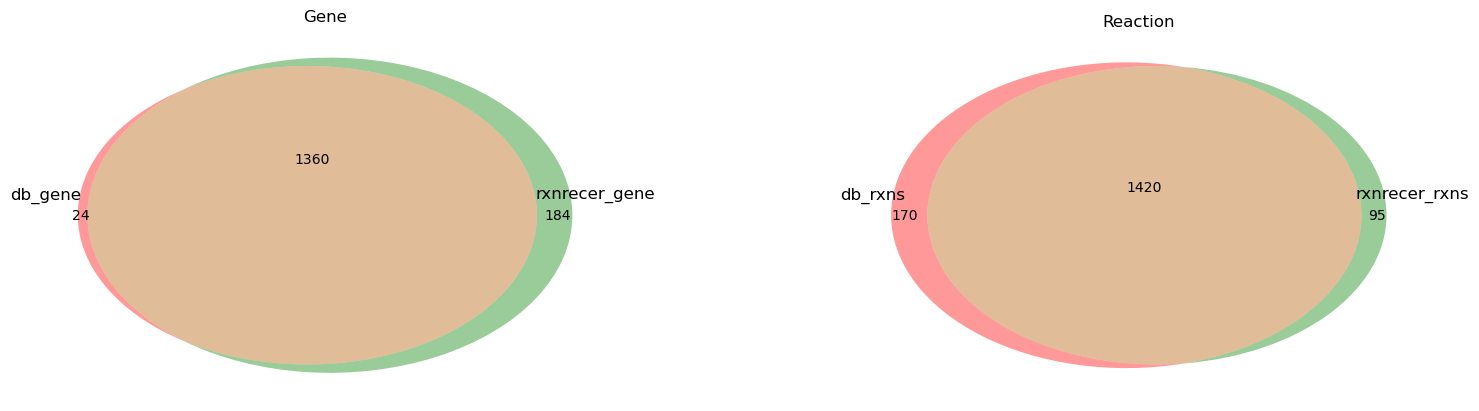

In [360]:

# 创建一个包含 1 行 2 列的子图结构
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

# 第一个子图 (ax1) - gene Venn 图
plt.sca(ax1)  # 设置当前子图为 ax1
venn_diagram1 = venn2([db_gene_ids_set, rxnrecer_gene_ids_set], set_labels=('db_gene', 'rxnrecer_gene'))

# 调整第一个 Venn 图的标签位置
venn_diagram1.get_label_by_id('10').set_x(-0.55)  
venn_diagram1.get_label_by_id('01').set_x(0.55)   
venn_diagram1.get_label_by_id('11').set_y(0.2)  
venn_diagram1.get_label_by_id('A').set_position((-0.55, 0.1))  
venn_diagram1.get_label_by_id('B').set_position((0.5, 0.1))  
ax1.set_aspect(0.65)  # 调整纵横比，使图形变为椭圆

# 添加第一个子图的标题
ax1.set_title('Gene')

# 第二个子图 (ax2) - reaction Venn 图
plt.sca(ax2)  # 设置当前子图为 ax2
venn_diagram2 = venn2([db_rxn_ids_set, rxnrecer_rxn_ids_set], set_labels=('db_rxns', 'rxnrecer_rxns'))

# 调整第二个 Venn 图的标签位置
venn_diagram2.get_label_by_id('10').set_x(-0.55)  
venn_diagram2.get_label_by_id('01').set_x(0.55)   
venn_diagram2.get_label_by_id('11').set_y(0.1)  
venn_diagram2.get_label_by_id('A').set_position((-0.55, 0.1))  
venn_diagram2.get_label_by_id('B').set_position((0.5, 0.1))  

ax2.set_aspect(0.65)  # 调整纵横比，使图形变为椭圆
# 添加第二个子图的标题
ax2.set_title('Reaction')

# 调整子图布局，增加左右间距
plt.subplots_adjust(wspace=0.4)  # wspace 用来控制子图之间的水平间距

# 显示图表
plt.show()


In [383]:
db_unique_genes = db_gene_ids_set - rxnrecer_gene_ids_set

diff_genes = rlation_in_db[rlation_in_db.gene_name_bigg.isin(list(db_unique_genes))]

print(f"Number of unique genes in the database: {len(db_unique_genes)}")
print(f'Number of rxns for these unique genes: {len(set(diff_genes.reaction_id))}')

diff_genes

Number of unique genes in the database: 24
Number of rxns for these unique genes: 47


,gene_id,gene_name_bigg,reaction_id,ec_number,equation_chebi,equation_text
93,P39396,b4354,RHEA:64720,None,CHEBI:15378 + CHEBI:15361 = CHEBI:15378 + CHEB...,H(+)(out) + pyruvate(out) = H(+)(in) + pyruvat...
147,P39386,b4337,RHEA:29251,None,2 CHEBI:15378 + CHEBI:29101 = 2 CHEBI:15378 + ...,2 H(+)(out) + Na(+)(in) = 2 H(+)(in) + Na(+)(out)
148,P39386,b4337,RHEA:29467,None,CHEBI:15378 + CHEBI:29103 = CHEBI:15378 + CHEB...,H(+)(out) + K(+)(in) = H(+)(in) + K(+)(out)
195,P29018,b0887,RHEA:29783,None,CHEBI:30616 + CHEBI:15377 + CHEBI:35235 = CHEB...,ATP + H2O + L-cysteine(in) = ADP + H(+) + L-cy...
196,P29018,b0887,RHEA:29787,None,CHEBI:30616 + CHEBI:57925 + CHEBI:15377 = CHEB...,ATP + glutathione(in) + H2O = ADP + glutathion...
207,P56100,b4515,RHEA:40527,EC:7.1.1.7,2 CHEBI:17976 + 4 CHEBI:15378 + CHEBI:15379 = ...,2 a ubiquinol + 4 H(+)(in) + O2(in) = 2 a ubiq...
446,P02920,b0343,RHEA:28867,None,CHEBI:15378 + CHEBI:17716 = CHEBI:15378 + CHEB...,H(+)(in) + lactose(in) = H(+)(out) + lactose(out)
447,P02920,b0343,RHEA:28855,None,CHEBI:15378 + CHEBI:28053 = CHEBI:15378 + CHEB...,H(+)(in) + melibiose(in) = H(+)(out) + melibio...
483,P39344,b4265,RHEA:29571,None,CHEBI:15378 + CHEBI:17796 = CHEBI:15378 + CHEB...,H(+)(in) + L-idonate(in) = H(+)(out) + L-idona...
484,P39344,b4265,RHEA:28831,None,CHEBI:18391 + CHEBI:15378 = CHEBI:18391 + CHEB...,D-gluconate(in) + H(+)(in) = D-gluconate(out) ...


In [384]:
# 找出在 rxnrecer 中有但在 db 中没有的基因
rxn_unique_genes = rxnrecer_gene_ids_set - db_gene_ids_set

# 从 rlation_in_merge 中筛选出这些基因对应的反应
diff_genes = rlation_in_RNXRECer[rlation_in_RNXRECer.gene_name_bigg.isin(list(rxn_unique_genes))]

# 打印结果
print(f"Number of unique genes in the rxn: {len(rxn_unique_genes)}")
print(f'Number of rxns for these unique genes: {len(set(diff_genes.reaction_id))}')

# 输出 diff_genes
diff_genes


Number of unique genes in the rxn: 184
Number of rxns for these unique genes: 153


,gene_id,gene_name_bigg,reaction_id,ec_number,equation_chebi,equation_text
51,P37595,b0828,RHEA:21016,EC:3.5.1.1;EC:3.5.1.38,CHEBI:15377 + CHEBI:58048 = CHEBI:29991 + CHEB...,H2O + L-asparagine = L-aspartate + NH4(+)
91,P17117,b0851,RHEA:21624,EC:1.5.1.38;EC:1.5.1.39,CHEBI:57618 + CHEBI:58349 = CHEBI:58210 + 2 CH...,FMNH2 + NADP(+) = FMN + 2 H(+) + NADPH
128,P23872,b0476,RHEA:21164,EC:3.1.1.1,CHEBI:33308 + CHEBI:15377 = CHEBI:29067 + CHEB...,a carboxylic ester + H2O = a carboxylate + an ...
164,P0A8V0,b2268,RHEA:10748,EC:4.2.1.1,CHEBI:15378 + CHEBI:17544 = CHEBI:16526 + CHEB...,H(+) + hydrogencarbonate = CO2 + H2O
167,P75792,b0822,RHEA:25197,EC:3.1.3.104,CHEBI:58421 + CHEBI:15377 = CHEBI:15934 + CHEB...,5-amino-6-(5-phospho-D-ribitylamino)uracil + H...
...,...,...,...,...,...,...
2086,P31062,b0560,RHEA:13065,EC:3.6.4.6;EC:3.6.4.7;EC:3.6.4.10;EC:3.6.4.12;...,CHEBI:30616 + CHEBI:15377 = CHEBI:456216 + CHE...,ATP + H2O = ADP + H(+) + phosphate
2087,P76418,b2099,RHEA:14493,EC:3.2.2.24,CHEBI:15377 + CHEBI:83960 = CHEBI:57967 + CHEB...,H2O + N(omega)-alpha-(ADP-D-ribosyl)-L-arginyl...
2088,P52048,b4465,RHEA:19661,EC:1.1.1.17,CHEBI:61381 + CHEBI:57540 = CHEBI:57634 + CHEB...,D-mannitol 1-phosphate + NAD(+) = beta-D-fruct...
2089,P71311,b0364,RHEA:33411,None,CHEBI:64870 + CHEBI:15377 = CHEBI:64871 + CHEB...,(S)-malyl N-acetyl-alpha-D-glucosaminide + H2O...


### 4.2  对比IML1515 gene

In [278]:
# 下载模型文件
if FIRST_TIME_RUN:
    ! wget -c http://bigg.ucsd.edu/static/models/iML1515.json
    
    
with open('iML1515.json', 'r', encoding='utf-8') as f:
    iml1515 = json.load(f)
    
iml1515_gene_ids = [gene['id'] for gene in iml1515['genes']]
print(f'Gene ids in iML1515: {len(iml1515_gene_ids)}')

Gene ids in iML1515: 1516


In [288]:
iml1515_gene_ids_set = set(iml1515_gene_ids)



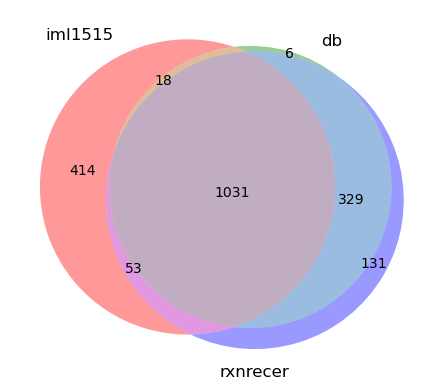

In [386]:


# 绘制 3 集合的 Venn 图
venn_diagram = venn3([iml1515_gene_ids_set, db_gene_ids_set, rxnrecer_gene_ids_set], 
                     set_labels=('iml1515', 'db', 'rxnrecer'))

# 显示图表
plt.show()


In [401]:
pd.set_option('max_colwidth',100)
rlation_in_RNXRECer[rlation_in_RNXRECer.gene_name_bigg.isin(list(rxnrecer_gene_ids_set - iml1515_gene_ids_set))].to_excel('ecoli_rxnrecer_relation_without_iml1515.xlsx')

In [ ]:
list(db_gene_ids_set - iml1515_gene_ids_set)

In [391]:
db_gene_ids_set - iml1515_gene_ids_set

{'-',
 'b0026',
 'b0028',
 'b0039',
 'b0051',
 'b0053',
 'b0058',
 'b0060',
 'b0082',
 'b0143',
 'b0147',
 'b0148',
 'b0167',
 'b0184',
 'b0188',
 'b0191',
 'b0194',
 'b0195',
 'b0215',
 'b0219',
 'b0231',
 'b0239',
 'b0262',
 'b0284',
 'b0285',
 'b0286',
 'b0342',
 'b0385',
 'b0391',
 'b0405',
 'b0406',
 'b0419',
 'b0424',
 'b0436',
 'b0443',
 'b0457',
 'b0470',
 'b0503',
 'b0525',
 'b0526',
 'b0581',
 'b0599',
 'b0600',
 'b0618',
 'b0634',
 'b0636',
 'b0640',
 'b0642',
 'b0661',
 'b0680',
 'b0711',
 'b0712',
 'b0713',
 'b0714',
 'b0797',
 'b0798',
 'b0799',
 'b0801',
 'b0807',
 'b0812',
 'b0824',
 'b0833',
 'b0834',
 'b0835',
 'b0838',
 'b0859',
 'b0873',
 'b0885',
 'b0893',
 'b0921',
 'b0927',
 'b0930',
 'b0948',
 'b0949',
 'b0962',
 'b0967',
 'b0981',
 'b0982',
 'b1045',
 'b1046',
 'b1055',
 'b1066',
 'b1086',
 'b1087',
 'b1099',
 'b1120',
 'b1128',
 'b1133',
 'b1135',
 'b1168',
 'b1180',
 'b1191',
 'b1204',
 'b1212',
 'b1218',
 'b1266',
 'b1269',
 'b1309',
 'b1313',
 'b1314',
 'b1

In [403]:
iml1515_gene_ids_set - db_gene_ids_set

{'b0007',
 'b0010',
 'b0030',
 'b0047',
 'b0054',
 'b0067',
 'b0068',
 'b0070',
 'b0084',
 'b0110',
 'b0150',
 'b0151',
 'b0152',
 'b0153',
 'b0158',
 'b0197',
 'b0198',
 'b0211',
 'b0237',
 'b0241',
 'b0260',
 'b0306',
 'b0307',
 'b0308',
 'b0336',
 'b0341',
 'b0344',
 'b0365',
 'b0367',
 'b0376',
 'b0401',
 'b0402',
 'b0403',
 'b0411',
 'b0429',
 'b0430',
 'b0432',
 'b0433',
 'b0451',
 'b0462',
 'b0463',
 'b0465',
 'b0493',
 'b0543',
 'b0572',
 'b0573',
 'b0574',
 'b0575',
 'b0577',
 'b0584',
 'b0589',
 'b0590',
 'b0591',
 'b0592',
 'b0597',
 'b0604',
 'b0606',
 'b0612',
 'b0617',
 'b0635',
 'b0641',
 'b0650',
 'b0651',
 'b0653',
 'b0654',
 'b0655',
 'b0681',
 'b0684',
 'b0696',
 'b0698',
 'b0709',
 'b0721',
 'b0722',
 'b0751',
 'b0752',
 'b0763',
 'b0764',
 'b0784',
 'b0805',
 'b0808',
 'b0809',
 'b0810',
 'b0811',
 'b0813',
 'b0819',
 'b0822',
 'b0828',
 'b0830',
 'b0831',
 'b0832',
 'b0837',
 'b0839',
 'b0842',
 'b0849',
 'b0854',
 'b0856',
 'b0857',
 'b0860',
 'b0861',
 'b0862',


/hpcfs/fhome/shizhenkun/miniconda3/envs/rxnrecer/lib/python3.10/site-packages/upsetplot/plotting.py:795: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  styles["linewidth"].fillna(1, inplace=True)
/hpcfs/fhome/shizhenkun/miniconda3/envs/rxnrecer/lib/python3.10/site-packages/upsetplot/plotting.py:796: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate o

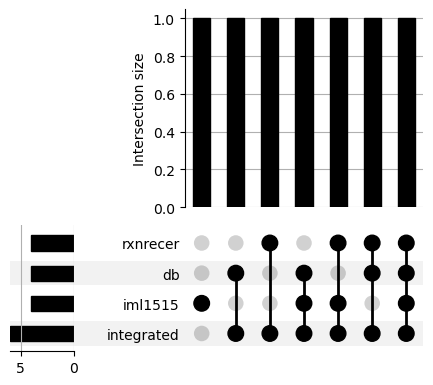

In [293]:
import pandas as pd
from upsetplot import UpSet
from collections import defaultdict

# 定义四个集合
iml1515_gene_ids_set = set(iml1515_gene_ids)
db_gene_ids_set = set(rlation_in_db.gene_name_bigg)
rxnrecer_gene_ids_set = set(rlation_in_RNXRECer.gene_name_bigg)
integrated_gene_ids_set = set(rlation_in_merge.gene_name_bigg)

# 计算交集关系
intersection_data = defaultdict(int)
all_sets = [iml1515_gene_ids_set, db_gene_ids_set, rxnrecer_gene_ids_set, integrated_gene_ids_set]

# 生成每个基因 ID 的集合组合
for gene in set.union(*all_sets):
    membership = tuple(gene in s for s in all_sets)
    intersection_data[membership] += 1

# 将结果转换为 DataFrame 并绘制 UpSet 图
df = pd.Series(intersection_data)

# 设置索引的名称为集合的名称，避免 None 重复问题
df.index.names = ['iml1515', 'db', 'rxnrecer', 'integrated']

# 绘制 UpSet 图
UpSet(df, subset_size='count').plot()

plt.show()




In [283]:
len(set(iml1515_gene_ids) & set(rlation_in_db.gene_name_bigg))

1049

In [279]:
rlation_in_merge[~rlation_in_merge.gene_name_bigg.isin(iml1515_gene_ids)]

,gene_id,gene_name_bigg,reaction_id,ec_number,equation_chebi,equation_text
7,P77766,b1266,RHEA:43532,EC:3.1.3.97,CHEBI:83402 + CHEBI:15377 = CHEBI:58043 + CHEB...,"a ribonucleoside 3',5'-bisphosphate + H2O = a ..."
37,P33644,b2593,RHEA:24408,EC:3.5.4.4,CHEBI:16335 + CHEBI:15378 + CHEBI:15377 = CHEB...,adenosine + H(+) + H2O = inosine + NH4(+)
38,P33644,b2593,RHEA:27642,EC:2.4.2.1,CHEBI:16335 + CHEBI:43474 = CHEBI:16708 + CHEB...,adenosine + phosphate = adenine + alpha-D-ribo...
39,P33644,b2593,RHEA:27646,EC:2.4.2.1,CHEBI:17596 + CHEBI:43474 = CHEBI:57720 + CHEB...,inosine + phosphate = alpha-D-ribose 1-phospha...
40,P33644,b2593,RHEA:11852,EC:2.4.2.28,CHEBI:43474 + CHEBI:17509 = CHEBI:16708 + CHEB...,phosphate + S-methyl-5'-thioadenosine = adenin...
...,...,...,...,...,...,...
2335,P52048,b4465,RHEA:19661,EC:1.1.1.17,CHEBI:61381 + CHEBI:57540 = CHEBI:57634 + CHEB...,D-mannitol 1-phosphate + NAD(+) = beta-D-fruct...
2336,P71311,b0364,RHEA:33411,None,CHEBI:64870 + CHEBI:15377 = CHEBI:64871 + CHEB...,(S)-malyl N-acetyl-alpha-D-glucosaminide + H2O...
2337,P0AAV8,b0769,RHEA:28931,EC:5.3.2.8,CHEBI:57471 = CHEBI:58142,"(1E)-4-oxobut-1-ene-1,2,4-tricarboxylate = 4-c..."
2338,K0JFS6,-,RHEA:46164,EC:1.6.5.2;EC:1.6.5.10,CHEBI:132124 + CHEBI:15378 + CHEBI:57783 = CHE...,a quinone + H(+) + NADPH = a quinol + NADP(+)


In [79]:
case_ecoli['lb_rxn_groundtruth'] = case_ecoli.reaction_id.parallel_apply(lambda x: cmfunc.make_label(reaction_id=str(x), rxn_label_dict=dict_rxn2id)) #make label for each blast prediction
case_ecoli['lb_rxn_RXNRECer'] = case_ecoli.RXNRECer.parallel_apply(lambda x: cmfunc.make_label(reaction_id=str(x), rxn_label_dict=dict_rxn2id)) #make label for each blast prediction
metrics_rxn_enzyme = cmfunc.rxn_eva_metric(eva_df=case_ecoli, eva_name='[RXN ECOLI]', methods=['RXNRECer'])
metrics_rxn_enzyme

Evaluating: Reaction Predcition Results [RXN ECOLI]


,baselineName,mAccuracy,mPrecision,mRecall,mF1
0,RXNRECer,0.927695,0.981561,0.917729,0.928603


In [80]:
ds_train =pd.read_feather(cfg.FILE_DS_TRAIN)
uniprot_id_in_train =  case_ecoli[case_ecoli.uniprot_id.isin(ds_train.uniprot_id)].uniprot_id.tolist()

r_in_train = case_ecoli[case_ecoli.uniprot_id.isin(uniprot_id_in_train)]
mr_in_train = cmfunc.rxn_eva_metric(eva_df=r_in_train, eva_name='[RXN ECOLI]', methods=['RXNRECer'])

r_notin_train = case_ecoli[~case_ecoli.uniprot_id.isin(uniprot_id_in_train)]
mr_notin_train = cmfunc.rxn_eva_metric(eva_df=r_notin_train, eva_name='[RXN ECOLI]', methods=['RXNRECer'])


print(f'Ecoli Records:{len(case_ecoli)}')
print(f'Overall Performance：\n{metrics_rxn_enzyme}\n')


print(f'Ecoli Records appeared in training set:{len(uniprot_id_in_train)}')
print(f'Performance：\n{mr_in_train}\n')


print(f'Ecoli Records not appeared in training set:{len(r_notin_train)}')
print(f'Performance：\n{mr_notin_train}\n')

Evaluating: Reaction Predcition Results [RXN ECOLI]
Evaluating: Reaction Predcition Results [RXN ECOLI]
Ecoli Records:4481
Overall Performance：
  baselineName  mAccuracy  mPrecision   mRecall       mF1
0     RXNRECer   0.927695    0.981561  0.917729  0.928603

Ecoli Records appeared in training set:3966
Performance：
  baselineName  mAccuracy  mPrecision  mRecall       mF1
0     RXNRECer   0.962683    0.990722  0.94547  0.946426

Ecoli Records not appeared in training set:515
Performance：
  baselineName  mAccuracy  mPrecision   mRecall       mF1
0     RXNRECer   0.658252         1.0  0.669231  0.800751



In [81]:
case_ecoli[case_ecoli.lb_rxn_groundtruth != case_ecoli.lb_rxn_RXNRECer]

,uniprot_id,reviewed,protein_name,gene_names,organism_name,length,ec,reaction_id,seq,lb_rxn_groundtruth,RXNRECer,equations,equations_chebi,lb_rxn_RXNRECer
28,P31658,reviewed,Protein/nucleic acid deglycase 1 (EC 3.1.2.-) ...,hchA yedU yzzC b1967 JW1950,Escherichia coli (strain K12),283,3.1.2.-;;3.5.1.-;;3.5.1.124;;4.2.1.130,RHEA:27754;RHEA:49548;RHEA:49552;RHEA:49556;RH...,MTVQTSKNPQVDIAEDNAFFPSEYSLSQYTSPVSDLDGVDYPKPYR...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",RHEA:57304;RHEA:57300;RHEA:57248;RHEA:57260;RH...,[H2O + N(2)-(1-hydroxy-2-oxoethyl)-GMP = glyco...,[CHEBI:15377 + CHEBI:141576 = CHEBI:29805 + CH...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
41,P37339,reviewed,L-2-hydroxyglutarate dehydrogenase (L2HG dehyd...,lhgD lhgO ygaF b2660 JW2635,Escherichia coli (strain K12),422,1.1.5.13,RHEA:58664,MYDFVIIGGGIIGMSTAMQLIDVYPDARIALLEKESAPACHQTGHN...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",RHEA:21252,[(S)-2-hydroxyglutarate + A = 2-oxoglutarate +...,[CHEBI:16782 + CHEBI:13193 = CHEBI:16810 + CHE...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
45,P37595,reviewed,Isoaspartyl peptidase (EC 3.4.19.5) (Beta-aspa...,iaaA spt ybiK b0828 JW0812,Escherichia coli (strain K12),321,3.4.19.5,-,MGKAVIAIHGGAGAISRAQMSLQQELRYIEALSAIVETGQKMLEAG...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",RHEA:21016,[H2O + L-asparagine = L-aspartate + NH4(+)],[CHEBI:15377 + CHEBI:58048 = CHEBI:29991 + CHE...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
67,P37666,reviewed,Glyoxylate/hydroxypyruvate reductase B (EC 1.1...,ghrB tkrA yiaE b3553 JW5656,Escherichia coli (strain K12),324,1.1.1.215;;1.1.1.79;;1.1.1.81,RHEA:10992;RHEA:17905;RHEA:18657;RHEA:16653,MKPSVILYKALPDDLLQRLQEHFTVHQVANLSPQTVEQNAAIFAEA...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",RHEA:17905;RHEA:10992;RHEA:18657,[(R)-glycerate + NAD(+) = 3-hydroxypyruvate + ...,[CHEBI:16659 + CHEBI:57540 = CHEBI:17180 + CHE...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
76,Q46857,reviewed,"2,5-diketo-D-gluconic acid reductase A (2,5-DK...",dkgA yqhE b3012 JW5499,Escherichia coli (strain K12),275,1.1.1.274,RHEA:23828,MANPTVIKLQDGNVMPQLGLGVWQASNEEVITAIQKALEVGYRSID...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",RHEA:35111,"[2-dehydro-L-idonate + NADP(+) = 2,5-didehydro...",[CHEBI:36602 + CHEBI:58349 = CHEBI:11449 + CHE...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4146,P76418,reviewed,Uncharacterized protein YegU (EC 3.2.2.-),yegU b2099 JW2086,Escherichia coli (strain K12),334,3.2.2.-,-,MKTERILGALYGQALGDAMGMPSELWPRSRVKAHFGWIDRFLPGPK...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",RHEA:14493,[H2O + N(omega)-alpha-(ADP-D-ribosyl)-L-arginy...,[CHEBI:15377 + CHEBI:83960 = CHEBI:57967 + CHE...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4312,P52048,reviewed,Uncharacterized protein YggP,yggP b4465 JW5477,Escherichia coli (strain K12),425,-,-,MKTKVAAIYGKRDVRLRVFELPEITDNELLVSVISDSVCLSTWKAA...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",RHEA:19661,[D-mannitol 1-phosphate + NAD(+) = beta-D-fruc...,[CHEBI:61381 + CHEBI:57540 = CHEBI:57634 + CHE...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4420,P71311,reviewed,Uncharacterized deacetylase YaiS (EC 3.-.-.-),yaiS b0364 JW0356,Escherichia coli (strain K12),185,3.-.-.-,-,MDKVLDSALLSSANKRKGILAIGAHPDDIELGCGASLARLAQKGIY...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",RHEA:33411,[(S)-malyl N-acetyl-alpha-D-glucosaminide + H2...,[CHEBI:64870 + CHEBI:15377 = CHEBI:64871 + CHE...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4421,P0AAV8,reviewed,Putative isomerase YbhH (EC 5.-.-.-),ybhH b0769 JW0752,Escherichia coli (strain K12),350,5.-.-.-,-,MKKIPCVMMRGGTSRGAFLLAEHLPEDQTQRDKILMAIMGSGNDLE...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",RHEA:28931,"[(1E)-4-oxobut-1-ene-1,2,4-tricarboxylate = 4-...",[CHEBI:57471 = CHEBI:58142],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [83]:
new_findeing = case_ecoli[(case_ecoli.reaction_id=='-')&( case_ecoli.RXNRECer!='-')].reset_index(drop=True)
new_findeing

,uniprot_id,reviewed,protein_name,gene_names,organism_name,length,ec,reaction_id,seq,lb_rxn_groundtruth,RXNRECer,equations,equations_chebi,lb_rxn_RXNRECer
0,P37595,reviewed,Isoaspartyl peptidase (EC 3.4.19.5) (Beta-aspa...,iaaA spt ybiK b0828 JW0812,Escherichia coli (strain K12),321,3.4.19.5,-,MGKAVIAIHGGAGAISRAQMSLQQELRYIEALSAIVETGQKMLEAG...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",RHEA:21016,[H2O + L-asparagine = L-aspartate + NH4(+)],[CHEBI:15377 + CHEBI:58048 = CHEBI:29991 + CHE...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,P17117,reviewed,Oxygen-insensitive NADPH nitroreductase (EC 1....,nfsA mda18 mdaA ybjB b0851 JW0835,Escherichia coli (strain K12),240,1.-.-.-,-,MTPTIELICGHRSIRHFTDEPISEAQREAIINSARATSSSSFLQCS...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",RHEA:21624,[FMNH2 + NADP(+) = FMN + 2 H(+) + NADPH],[CHEBI:57618 + CHEBI:58349 = CHEBI:58210 + CHE...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,P23872,reviewed,Acetyl esterase (EC 3.1.1.-) (EcE),aes ybaC b0476 JW0465,Escherichia coli (strain K12),319,3.1.1.-,-,MKPENKLPVLDLISAEMKTVVNTLQPDLPPWPATGTIAEQRQYYTL...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",RHEA:21164,[a carboxylic ester + H2O = a carboxylate + an...,[CHEBI:33308 + CHEBI:15377 = CHEBI:29067 + CHE...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,P0A8V0,reviewed,Ribonuclease BN (RNase BN) (EC 3.1.-.-) (Ribon...,rbn elaC rnz b2268 JW2263,Escherichia coli (strain K12),305,3.1.-.-,-,MELIFLGTSAGVPTRTRNVTAILLNLQHPTQSGLWLFDCGEGTQHQ...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",RHEA:10748,[H(+) + hydrogencarbonate = CO2 + H2O],[CHEBI:15378 + CHEBI:17544 = CHEBI:16526 + CHE...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,P75792,reviewed,Sugar phosphatase YbiV (EC 3.1.3.23),ybiV supH b0822 JW0806,Escherichia coli (strain K12),271,3.1.3.23,-,MSVKVIVTDMDGTFLNDAKTYNQPRFMAQYQELKKRGIKFVVASGN...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",RHEA:25197,[5-amino-6-(5-phospho-D-ribitylamino)uracil + ...,[CHEBI:58421 + CHEBI:15377 = CHEBI:15934 + CHE...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
182,P76418,reviewed,Uncharacterized protein YegU (EC 3.2.2.-),yegU b2099 JW2086,Escherichia coli (strain K12),334,3.2.2.-,-,MKTERILGALYGQALGDAMGMPSELWPRSRVKAHFGWIDRFLPGPK...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",RHEA:14493,[H2O + N(omega)-alpha-(ADP-D-ribosyl)-L-arginy...,[CHEBI:15377 + CHEBI:83960 = CHEBI:57967 + CHE...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
183,P52048,reviewed,Uncharacterized protein YggP,yggP b4465 JW5477,Escherichia coli (strain K12),425,-,-,MKTKVAAIYGKRDVRLRVFELPEITDNELLVSVISDSVCLSTWKAA...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",RHEA:19661,[D-mannitol 1-phosphate + NAD(+) = beta-D-fruc...,[CHEBI:61381 + CHEBI:57540 = CHEBI:57634 + CHE...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
184,P71311,reviewed,Uncharacterized deacetylase YaiS (EC 3.-.-.-),yaiS b0364 JW0356,Escherichia coli (strain K12),185,3.-.-.-,-,MDKVLDSALLSSANKRKGILAIGAHPDDIELGCGASLARLAQKGIY...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",RHEA:33411,[(S)-malyl N-acetyl-alpha-D-glucosaminide + H2...,[CHEBI:64870 + CHEBI:15377 = CHEBI:64871 + CHE...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
185,P0AAV8,reviewed,Putative isomerase YbhH (EC 5.-.-.-),ybhH b0769 JW0752,Escherichia coli (strain K12),350,5.-.-.-,-,MKKIPCVMMRGGTSRGAFLLAEHLPEDQTQRDKILMAIMGSGNDLE...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",RHEA:28931,"[(1E)-4-oxobut-1-ene-1,2,4-tricarboxylate = 4-...",[CHEBI:57471 = CHEBI:58142],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [22]:
ds_rxn = pd.read_feather(cfg.FILE_DS_RHEA_REACTIONS)

In [25]:
ds_rxn.to_feather(cfg.FILE_DS_RHEA_REACTIONS)

In [21]:
new_findeing

,uniprot_id,reviewed,protein_name,gene_names,organism_name,length,ec,reaction_id,seq,RXNRECer,lb_rxn_groundtruth,lb_rxn_RXNRECer
0,P37595,reviewed,Isoaspartyl peptidase (EC 3.4.19.5) (Beta-aspa...,iaaA spt ybiK b0828 JW0812,Escherichia coli (strain K12),321,3.4.19.5,-,MGKAVIAIHGGAGAISRAQMSLQQELRYIEALSAIVETGQKMLEAG...,RHEA:21016,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,P17117,reviewed,Oxygen-insensitive NADPH nitroreductase (EC 1....,nfsA mda18 mdaA ybjB b0851 JW0835,Escherichia coli (strain K12),240,1.-.-.-,-,MTPTIELICGHRSIRHFTDEPISEAQREAIINSARATSSSSFLQCS...,RHEA:21624,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,P23872,reviewed,Acetyl esterase (EC 3.1.1.-) (EcE),aes ybaC b0476 JW0465,Escherichia coli (strain K12),319,3.1.1.-,-,MKPENKLPVLDLISAEMKTVVNTLQPDLPPWPATGTIAEQRQYYTL...,RHEA:21164,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,P0A8V0,reviewed,Ribonuclease BN (RNase BN) (EC 3.1.-.-) (Ribon...,rbn elaC rnz b2268 JW2263,Escherichia coli (strain K12),305,3.1.-.-,-,MELIFLGTSAGVPTRTRNVTAILLNLQHPTQSGLWLFDCGEGTQHQ...,RHEA:10748,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,P75792,reviewed,Sugar phosphatase YbiV (EC 3.1.3.23),ybiV supH b0822 JW0806,Escherichia coli (strain K12),271,3.1.3.23,-,MSVKVIVTDMDGTFLNDAKTYNQPRFMAQYQELKKRGIKFVVASGN...,RHEA:25197,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...
182,P76418,reviewed,Uncharacterized protein YegU (EC 3.2.2.-),yegU b2099 JW2086,Escherichia coli (strain K12),334,3.2.2.-,-,MKTERILGALYGQALGDAMGMPSELWPRSRVKAHFGWIDRFLPGPK...,RHEA:14493,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
183,P52048,reviewed,Uncharacterized protein YggP,yggP b4465 JW5477,Escherichia coli (strain K12),425,-,-,MKTKVAAIYGKRDVRLRVFELPEITDNELLVSVISDSVCLSTWKAA...,RHEA:19661,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
184,P71311,reviewed,Uncharacterized deacetylase YaiS (EC 3.-.-.-),yaiS b0364 JW0356,Escherichia coli (strain K12),185,3.-.-.-,-,MDKVLDSALLSSANKRKGILAIGAHPDDIELGCGASLARLAQKGIY...,RHEA:33411,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
185,P0AAV8,reviewed,Putative isomerase YbhH (EC 5.-.-.-),ybhH b0769 JW0752,Escherichia coli (strain K12),350,5.-.-.-,-,MKKIPCVMMRGGTSRGAFLLAEHLPEDQTQRDKILMAIMGSGNDLE...,RHEA:28931,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [25]:
case_ecoli_res.gene_names

0       casA cse1 ygcL b2760 JW2730
1       dtpA tppB ydgR b1634 JW1626
2            dtpB yhiP b3496 JW3463
3       bluF blrp ycgF b1163 JW1150
4            dtpC yjdL b4130 JW4091
                   ...             
4476                           wrbA
4477                           yncM
4478                              -
4479                           yfjV
4480                            int
Name: gene_names, Length: 4481, dtype: object

In [27]:
import re

# 原始字符串
input_string = "casA cse1 ygcL b2760 JW2730"

# 分割字符串为数组
items = input_string.split()

# 提取以 'b' 开头的ID
b_ids = [item for item in items if re.match(r'^b\d+$', item)]
b_ids

['b2760']